# Module Importing

In [1]:
import os
os.chdir('..')

In [2]:
import gc

In [3]:
import datetime

In [4]:
import pandas as pd
import numpy as np

In [5]:
import re

In [6]:
import lightgbm as lgb
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
from itertools import product

In [9]:
from tqdm import tqdm_notebook

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
sns.set(style="darkgrid")

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [14]:
%matplotlib inline

# Data Loading

## Data fields
+ **ID** - an Id that represents a (Shop, Item) tuple within the test set
+ **shop_id** - unique identifier of a shop
+ **item_id** - unique identifier of a product
+ **item_category_id** - unique identifier of item category
+ **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
+ **item_price** - current price of an item
+ **date** - date in format dd/mm/yyyy
+ **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
+ **item_name** - name of item
+ **shop_name** - name of shop
+ **item_category_name** - name of item category

## Sales_train
**(the training set. Daily historical data from January 2013 to October 2015)**

In [15]:
sales_train_df = pd.read_csv('data/sales_train.csv', parse_dates=['date'], 
                             dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                                    'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [16]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [17]:
print('Shape of sales_train.csv is (%d, %d)' % sales_train_df.shape)

Shape of sales_train.csv is (2935849, 6)


## Items
**(supplemental information about the items/products)**

In [18]:
items_df = pd.read_csv('data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})

In [19]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [20]:
print('Shape of items.csv is (%d, %d)' % items_df.shape)

Shape of items.csv is (22170, 3)


## Item_categories
**(supplemental information about the items categories)**

In [21]:
item_categories_df = pd.read_csv('data/item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

In [22]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [23]:
print('Shape of item_categories.csv is (%d, %d)' % item_categories_df.shape)

Shape of item_categories.csv is (84, 2)


## Shops
**(supplemental information about the shops)**

In [24]:
shops_df = pd.read_csv('data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

In [25]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [26]:
print('Shape of shops.csv is (%d, %d)' % shops_df.shape)

Shape of shops.csv is (60, 2)


## test
**(the test set. You need to forecast the sales for these shops and products for November 2015)**

In [27]:
test_df = pd.read_csv('data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                              'item_id': 'int32'})

In [28]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [29]:
print('Shape of test.csv is (%d, %d)' % test_df.shape)

Shape of test.csv is (214200, 3)


# Basic EDA

In [25]:
def intitial_eda_checks(df: pd.DataFrame) -> None:
    """
        1. Take a dataframe.
        2. Check if there is duplicates.
        3. Check if there is nulls.
    """

    # keep=False - marke all duplicates as True
    if len(df[df.duplicated(keep=False)]) > 0:
        print('- Number of duplicates = {}'.format(len(df[df.duplicated(keep=False)])))
    else:
        print('- No duplicates found.')

    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'- Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('- No NaN found.')

### Descriptive statistics, number of missing values, etc

**First and last 5 rows of DataFrame:**

In [24]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [24]:
sales_train_df.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


**Basic information about a DataFrame:**

In [25]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [26]:
intitial_eda_checks(sales_train_df)

- Number of duplicates = 12
- No NaN found.


In [27]:
print('- Number of unique items = ',
      len(sales_train_df['item_id'].unique()))
print('- Number of unique items, which appears only once  = ',
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1]))
print('- Number of unique items, which appears less or equal than 10 times  = ', 
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() < 10]))

- Number of unique items =  21807
- Number of unique items, which appears only once  =  2371
- Number of unique items, which appears less or equal than 10 times  =  6541


In [28]:
print('- Number of unique shops = ',
      len(sales_train_df['shop_id'].unique()))
print('- Number of unique shops, which appears only once  = ',
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() == 1]))
print('- Number of unique shops, which appears less or equal than 10000 times  = ', 
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() < 10000]))

- Number of unique shops =  60
- Number of unique shops, which appears only once  =  0
- Number of unique shops, which appears less or equal than 10000 times  =  12


In [29]:
len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1])

2371

**Top-10 popular items:**

In [30]:
top_10_items = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id')['item_name'].value_counts()[:50]).reset_index()
top_10_items.columns = ['item_name', 'count']

In [31]:
top_10_items.head(10)

,item_name,count
0,Фирменный пакет майка 1С Интерес белый (34*42)...,31340
1,Playstation Store пополнение бумажника: Карта ...,9408
2,Прием денежных средств для 1С-Онлайн,9067
3,"Diablo III [PC, Jewel, русская версия]",7479
4,Kaspersky Internet Security Multi-Device Russi...,6853
5,World of Warcraft. Карта оплаты игрового време...,6602
6,"Grand Theft Auto V [PS3, русские субтитры]",6475
7,"Call of Duty: Black Ops II [PС, Jewel, русская...",6320
8,"Minecraft [Xbox 360, английская версия]",5811
9,"Grand Theft Auto V [Xbox 360, русские субтитры]",5805


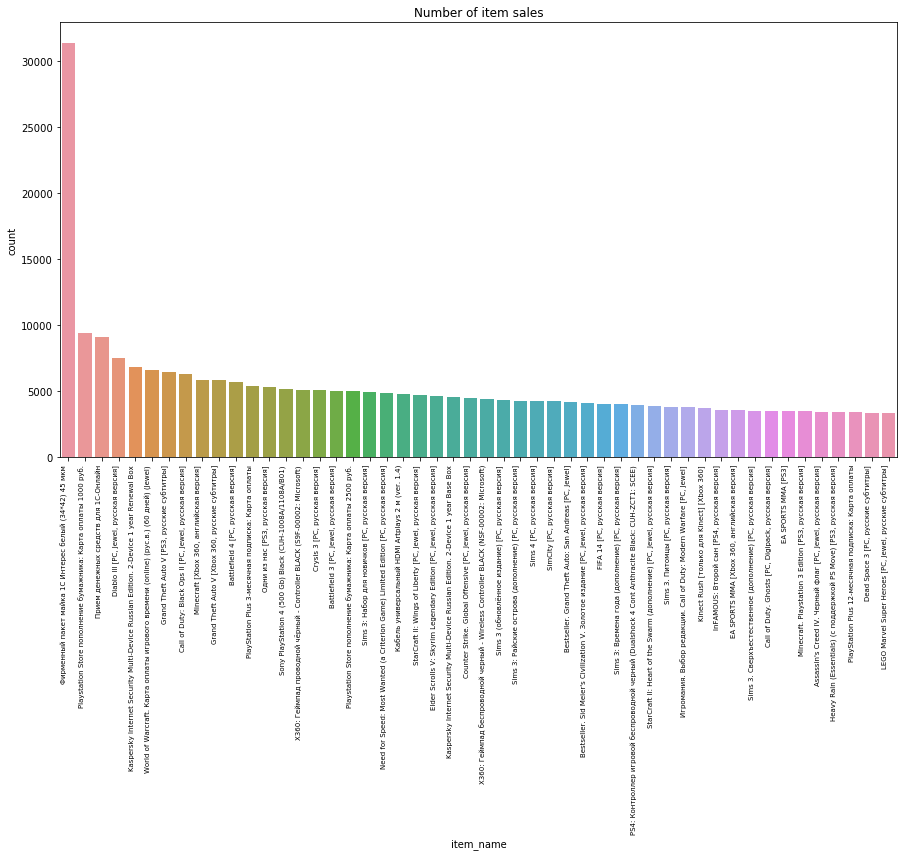

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="item_name", y='count', data=top_10_items)
ax.set_title("Number of item sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [35]:
del top_10_items

**Top-10 popular categories:**

In [43]:
top_10_categories = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id') \
                                               .merge(item_categories_df, left_on='item_category_id', right_on='item_category_id')['item_category_name'] \
                                               .value_counts() \
                                               .reset_index()[:50]
            )
top_10_categories.columns = ['caterory_name', 'count']

In [44]:
top_10_categories.head(10)

,caterory_name,count
0,Кино - DVD,564652
1,Игры PC - Стандартные издания,351591
2,Музыка - CD локального производства,339585
3,Игры - PS3,208219
4,Кино - Blu-Ray,192674
5,Игры - XBOX 360,146789
6,Игры PC - Дополнительные издания,121539
7,Игры - PS4,79058
8,Подарки - Мягкие игрушки,53845
9,Подарки - Настольные игры (компактные),53227


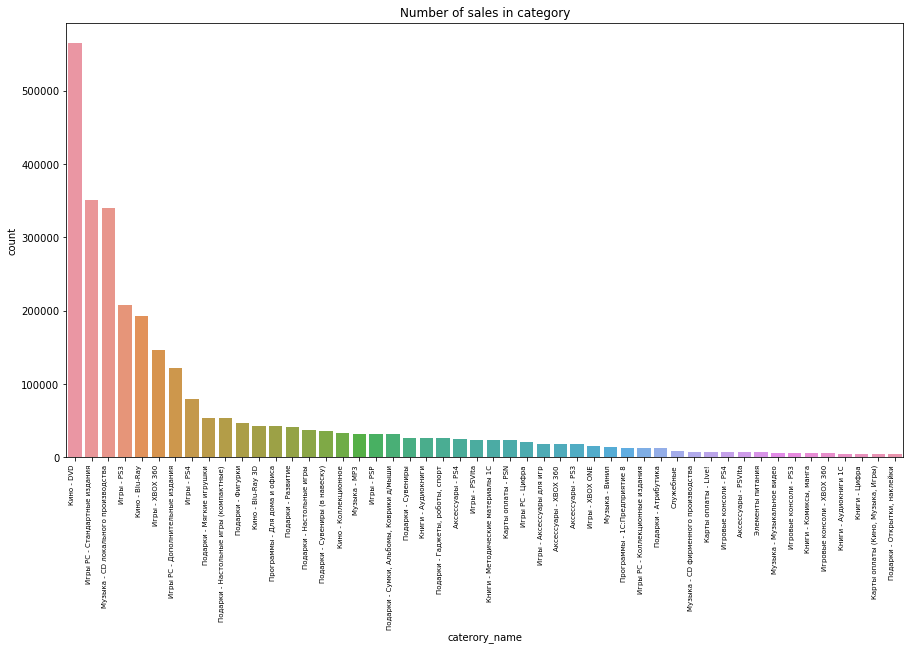

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="caterory_name", y='count', data=top_10_categories)
ax.set_title("Number of sales in category");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [46]:
del top_10_categories

**Top-10 popular shops:**

In [47]:
top_10_shops = pd.DataFrame(sales_train_df.merge(shops_df, left_on='shop_id', right_on='shop_id')['shop_name'] \
                                          .value_counts() \
                                          .reset_index()[:50])
top_10_shops.columns = ['shop_name', 'count']

In [48]:
top_10_shops.head(10)

,shop_name,count
0,"Москва ТЦ ""Семеновский""",235636
1,"Москва ТРК ""Атриум""",186104
2,"Химки ТЦ ""Мега""",143480
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",142234
4,"Якутск Орджоникидзе, 56",117428
5,"СПб ТК ""Невский Центр""",109253
6,"Москва ТЦ ""МЕГА Белая Дача II""",105366
7,"Воронеж (Плехановская, 13)",82663
8,"Якутск ТЦ ""Центральный""",71441
9,"Чехов ТРЦ ""Карнавал""",69573


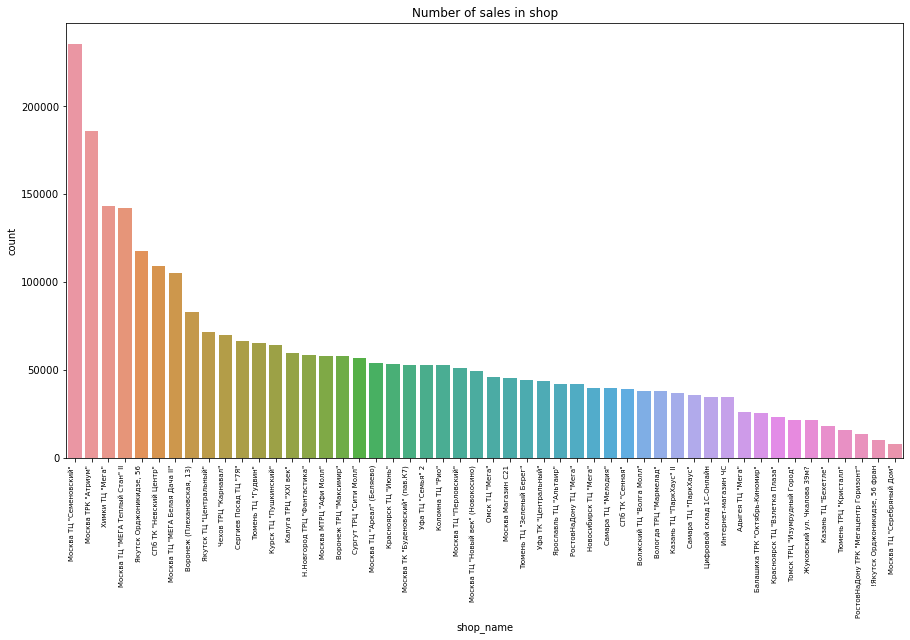

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="shop_name", y='count', data=top_10_shops)
ax.set_title("Number of sales in shop");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [50]:
del top_10_shops

**Monthly and daily sales:**

In [51]:
sales = sales_train_df.copy()

In [52]:
def revers_date(x: str):
    buf = x.split('.')
    return '.'.join([buf[2], buf[1], buf[0]])

In [53]:
sales['date'] = sales['date'].apply(revers_date)

In [55]:
sales.date.values.sort()

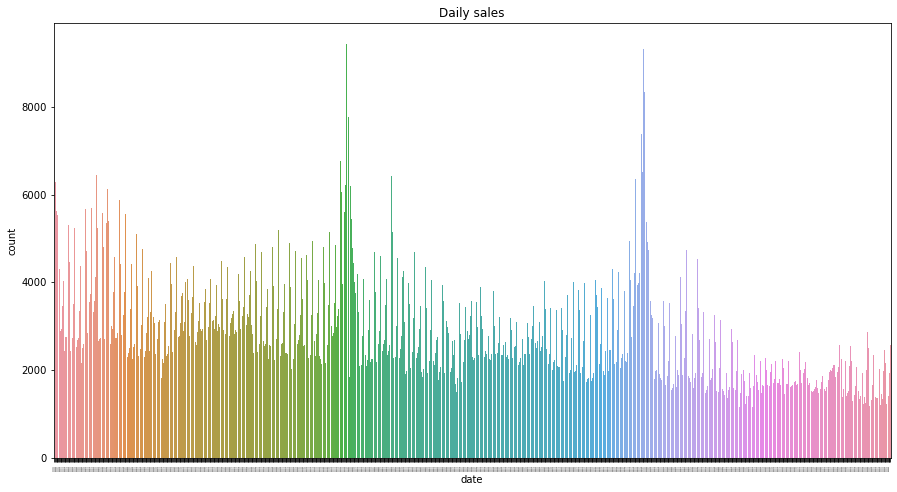

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Daily sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=0);

In [57]:
sales['date'] = sales['date'].apply(lambda x: x[:-3])

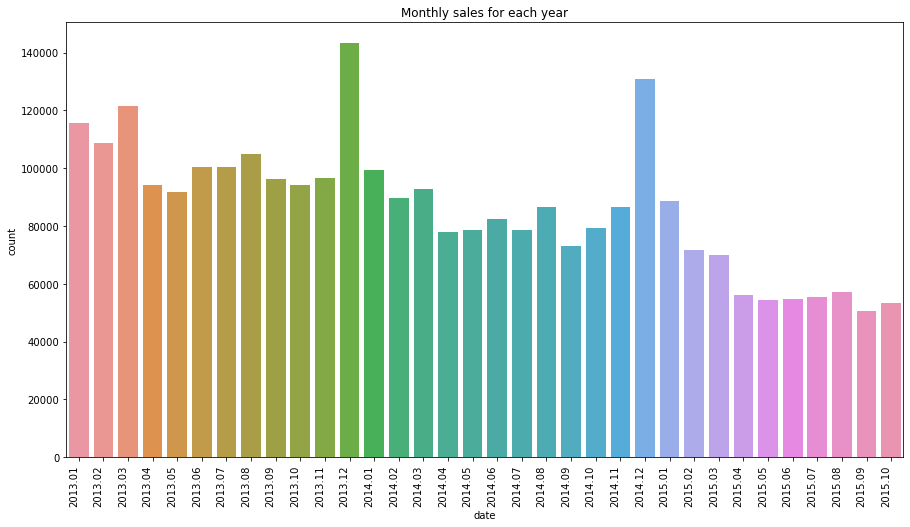

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Monthly sales for each year");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

In [59]:
sales['date'] = sales['date'].apply(lambda x: x[-2:])

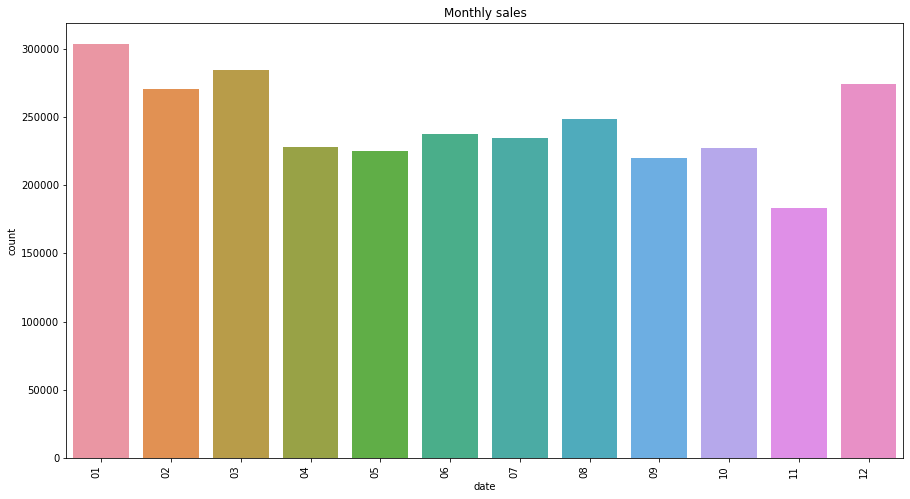

In [60]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Monthly sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

In [61]:
del sales

**How sales behaves along the year?**

In [84]:
monthly_sales = sales_train_df.copy()

In [86]:
monthly_sales = monthly_sales.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)

In [87]:
monthly_sales = monthly_sales.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [90]:
monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [92]:
monthly_sales['year'] = monthly_sales['date_block_num'].apply(lambda x: ((x//12) + 2013))
monthly_sales['month'] = monthly_sales['date_block_num'].apply(lambda x: (x % 12))

In [91]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,0,32,884.0,221.0,6.0,1.5,4
1,0,0,33,1041.0,347.0,3.0,1.0,3
2,0,0,35,247.0,247.0,1.0,1.0,1
3,0,0,43,221.0,221.0,1.0,1.0,1
4,0,0,51,257.0,128.5,2.0,1.0,2


In [93]:
gp_month_mean = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].sum()

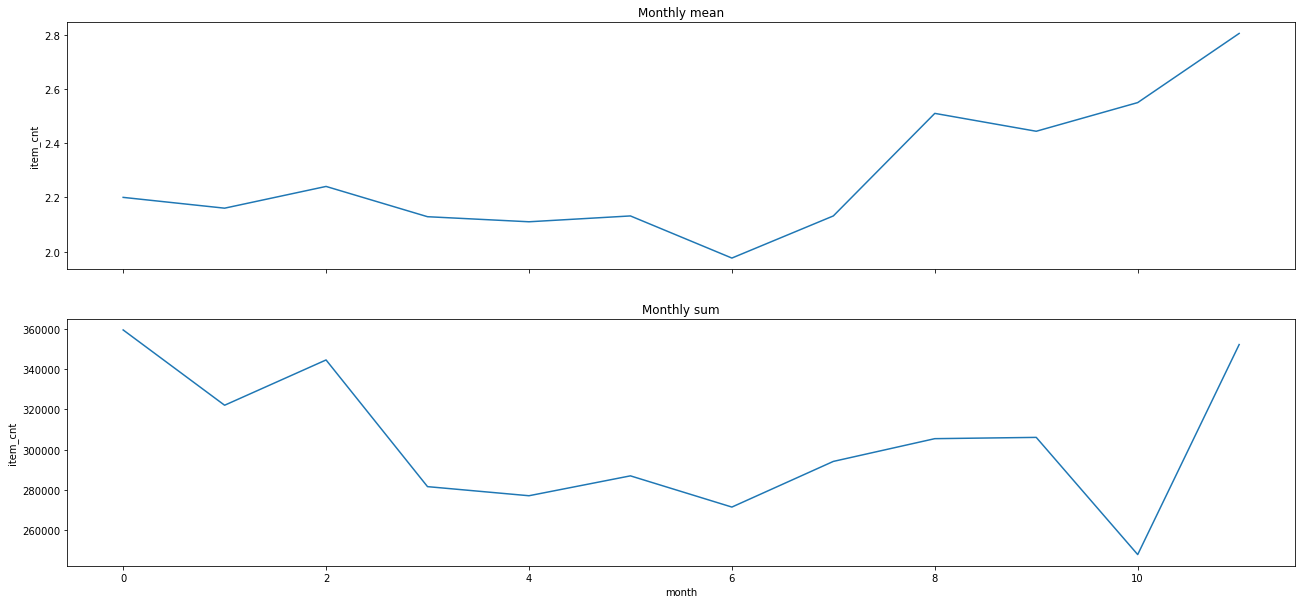

In [94]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

In [99]:
del gp_month_mean, gp_month_sum

**What shop sells more?**

In [95]:
gp_shop_mean = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

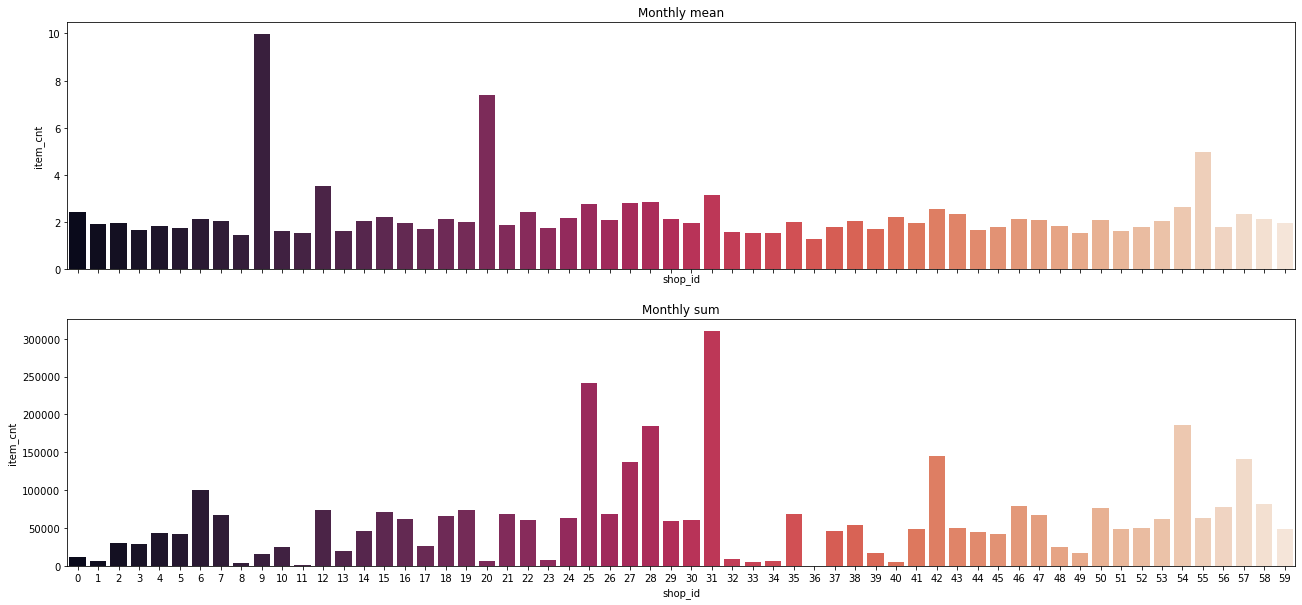

In [98]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [100]:
del gp_shop_mean, gp_shop_sum

**Checking for outliers:**

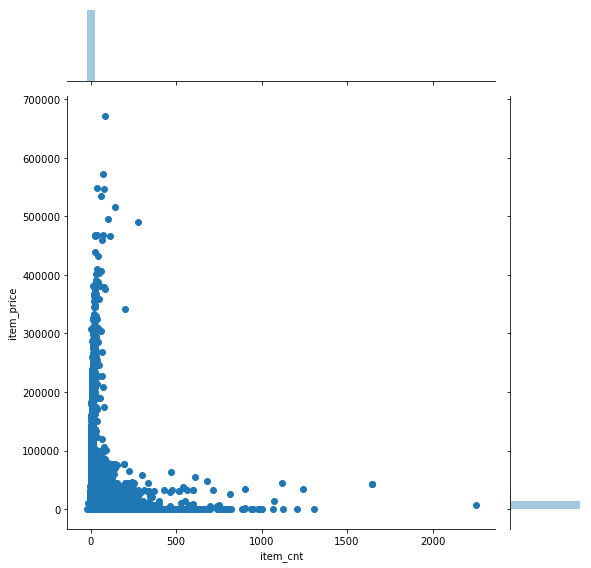

In [104]:
sns.jointplot(x="item_cnt", y="item_price", data=monthly_sales, height=8)

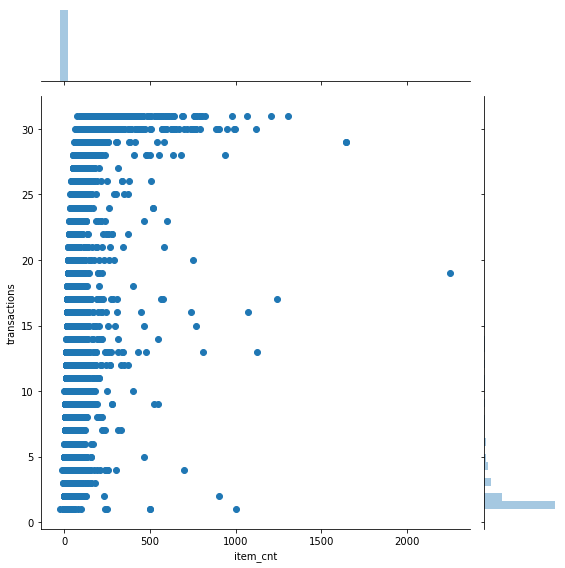

In [105]:
sns.jointplot(x="item_cnt", y="transactions", data=monthly_sales, height=8)

**Feature "item_cnt" distribution:**

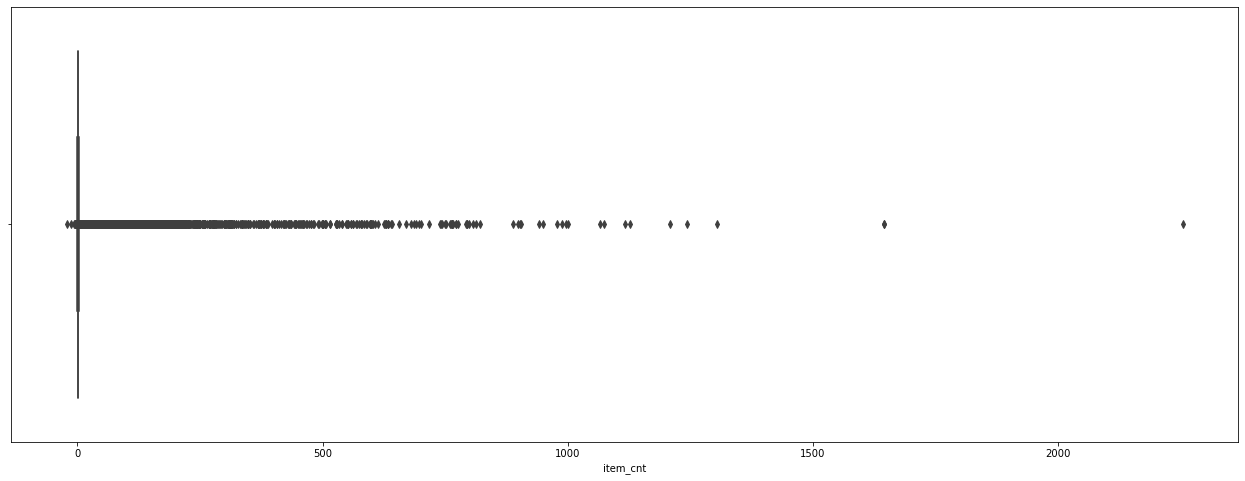

In [111]:
plt.subplots(figsize=(22, 8))
sns.boxplot(monthly_sales['item_cnt'])
plt.show()

In [131]:
del monthly_sales

**Number of item sales per month for each shop:**

In [64]:
grouped = pd.DataFrame(sales_train_df.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())

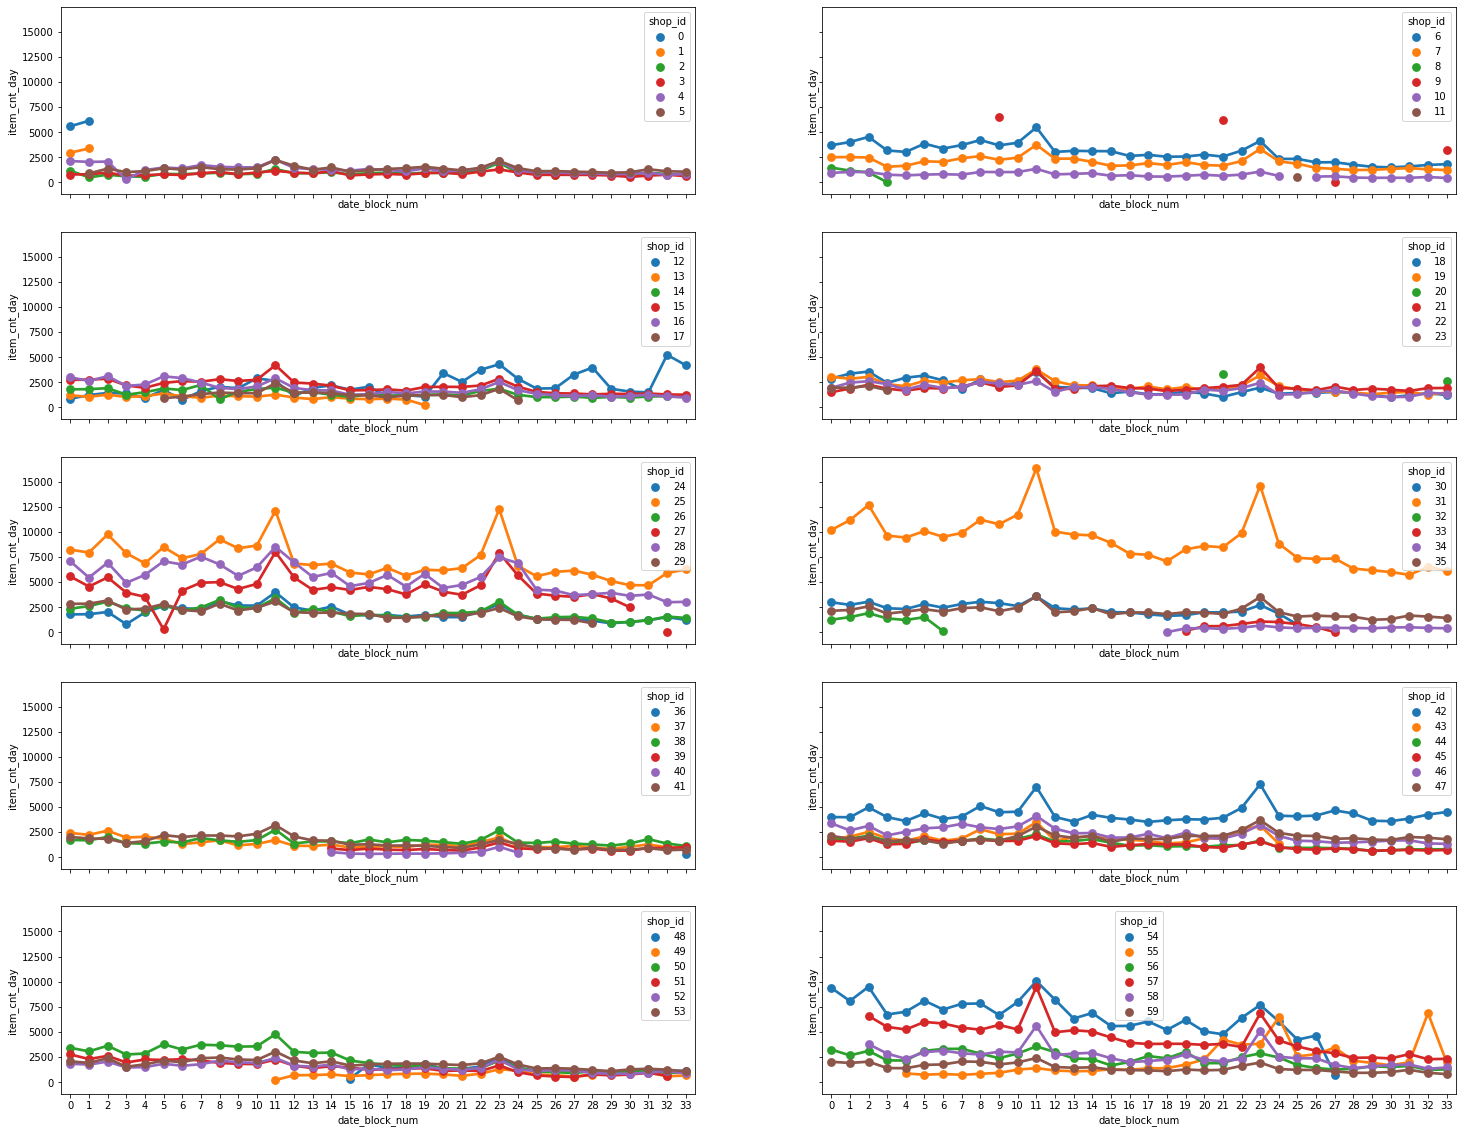

In [65]:
num_graph = 10
count = 0

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(25,20))
id_per_graph = np.ceil(grouped.shop_id.max() / num_graph)

for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id',
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)],
                      ax=axes[i][j])
        count += 1

In [68]:
del grouped

In [34]:
gc.collect()

30

# Basic data preparation

In [30]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Adding revenue column

In [31]:
# sales_train_df['revenue'] = sales_train_df['item_price'] * sales_train_df['item_cnt_day']

In [32]:
# sales_train_df.head()

### Join datasets

In [33]:
# train = sales_train_df.join(items_df, on='item_id', rsuffix='_') \
#                       .join(shops_df, on='shop_id', rsuffix='_') \
#                       .join(item_categories_df, on='item_category_id', rsuffix='_') \
#                       .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Time period of the dataset

In [34]:
print('Min date from train set: %s' % sales_train_df['date'].min().date())
print('Max date from train set: %s' % sales_train_df['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Date column to correct format

In [35]:
# sales_train_df['date'] = sales_train_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

### Adding information about category

In [36]:
sales_train_df = sales_train_df.join(items_df, on='item_id', rsuffix='_').drop(['item_id_', 'item_name'], axis=1)

### Dropping duplicates

In [37]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']

In [38]:
print('Duplicates: {}'.format(sales_train_df.duplicated(subset=subset).sum()))

Duplicates: 24


In [39]:
sales_train_df.drop_duplicates(subset=subset, inplace=True)

### Dropping negative price

In [40]:
sales_train_df = sales_train_df.query('item_price > 0')

### Data leakages. Dropping shops and items not in test data

In [41]:
test_shops = test_df.shop_id.unique()
test_items = test_df.item_id.unique()

In [42]:
train = sales_train_df[sales_train_df.shop_id.isin(test_shops)]
train = sales_train_df[sales_train_df.item_id.isin(test_items)]

In [43]:
del test_shops, test_items

In [44]:
gc.collect()

179

### Creating all combinations

In [45]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = sales_train_df.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False) \
                              .agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [ ]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [46]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [47]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

In [48]:
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [49]:
# Groupby data to get shop-item-month aggregates
gb = train.groupby(index_cols, as_index=False).agg({'item_cnt_day':['sum']})

# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 

# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [50]:
all_data.columns = ['shop_id', 'item_id', 'date_block_num', 'target']

In [51]:
# Same as above but with shop-month aggregates
gb = train.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

In [52]:
all_data.columns = ['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop']

In [53]:
# Same as above but with item-month aggregates  
gb = train.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

In [54]:
all_data.columns = ['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop', 'target_item']

In [55]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb, all_data

In [56]:
gc.collect()

2908

In [99]:
all_data

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,59,22154,0,1.0,452.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,59,2574,0,2.0,452.0,119.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
2,59,2607,0,0.0,452.0,29.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
3,59,2614,0,0.0,452.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,59,2808,0,15.0,452.0,858.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227800,21,8474,33,0.0,1863.0,1.0,1.0,3.0,1709.0,0.0,...,0.0,3.0,1628.0,0.0,1.0,1447.0,0.0,3.0,1322.0,43
3227801,21,7998,33,0.0,1863.0,1.0,0.0,1.0,1709.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1447.0,0.0,0.0,0.0,58
3227802,21,8169,33,0.0,1863.0,2.0,0.0,3.0,1709.0,0.0,...,0.0,0.0,0.0,0.0,2.0,1447.0,1.0,4.0,1322.0,55
3227803,21,7590,33,0.0,1863.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64


### Removing outliers

In [53]:
# train_month['item_cnt'].clip(0, 20, inplace=True)

In [54]:
# train_month = train_month.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

### Feature creation

#### Lags features

In [55]:
#cols_to_rename

In [56]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

In [57]:
for month_shift in shift_range:
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)


In [58]:
del train_shift

In [59]:
# Don't use old data from year 2013
# all_data = all_data[all_data['date_block_num'] >= 12] 

In [60]:
# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 

# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

In [61]:
# Category for each item
item_category_mapping = items_df[['item_id','item_category_id']].drop_duplicates()

In [62]:
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

In [63]:
gc.collect();

In [64]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,59,22154,0,1.0,452.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,59,2574,0,2.0,452.0,119.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
2,59,2607,0,0.0,452.0,29.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
3,59,2614,0,0.0,452.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,59,2808,0,15.0,452.0,858.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30


In [65]:
# all_data.to_csv('all_data.csv')

### Text feature creation

In [66]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [67]:
shops_df.loc[shops_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df['category'] = shops_df['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
shops_df.category = shops_df.category.apply(lambda x: x if (x in category) else 'etc')
shops_df.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', 'etc', 'ул.', 'Магазин', 'ТК',
       'склад'], dtype=object)

In [68]:
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops_df.category = shops_df.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', shops_df.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc           223
ТК            184
ТРК           140
ТРЦ           340
ТЦ            883


In [69]:
shops_df['shop_city'] = shops_df.city
shops_df['shop_category'] = shops_df.category

shops_df['shop_city'] = LabelEncoder().fit_transform(shops_df['shop_city'])
shops_df['shop_category'] = LabelEncoder().fit_transform(shops_df['shop_category'])

shops_df = shops_df[['shop_id','shop_city', 'shop_category']]
shops_df.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


In [70]:
item_categories_df['type_code'] = item_categories_df.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
item_categories_df.loc[(item_categories_df.type_code == 'Игровые') | (item_categories_df.type_code == 'Аксессуары'), 'category'] = 'Игры'
item_categories_df.loc[item_categories_df.type_code == 'PC', 'category'] = 'Музыка'

category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

item_categories_df['type_code'] = item_categories_df.type_code.apply(lambda x: x if (x in category) else 'etc')

print(item_categories_df.groupby(['type_code']).sum())
item_categories_df['type_code'] = LabelEncoder().fit_transform(item_categories_df['type_code'])

item_categories_df['split'] = item_categories_df.item_category_name.apply(lambda x: x.split('-'))
item_categories_df['subtype'] = item_categories_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories_df['subtype_code'] = LabelEncoder().fit_transform(item_categories_df['subtype'])
item_categories_df = item_categories_df[['item_category_id','type_code', 'subtype_code']]

           item_category_id
type_code                  
etc                     236
Игры                    343
Карты                   170
Кино                    195
Книги                   624
Музыка                  345
Подарки                 798
Программы               453
Служебные               159
Чистые                  163


In [71]:
item_categories_df.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,0,9
2,2,0,10
3,3,0,11
4,4,0,13


In [72]:
items_df

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [73]:
from collections import Counter
from operator import itemgetter

items_df['name_1'], items_df['name_2'] = items_df['item_name'].str.split('[', 1).str
items_df['name_1'], items_df['name_3'] = items_df['item_name'].str.split('(', 1).str

items_df['name_2'] = items_df['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items_df['name_3'] = items_df['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items_df = items_df.fillna('0')

result_1 = Counter(' '.join(items_df['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items_df['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items_df['item_name'] = items_df['item_name'].apply(lambda x: name_correction(x))
items_df.name_2 = items_df.name_2.apply(lambda x: x[:-1] if x != '0' else '0')

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


In [74]:
items_df['type'] = items_df.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
items_df.loc[(items_df.type == 'x360') | (items_df.type == 'xbox360'), 'type'] = 'xbox 360'
items_df.loc[items_df.type == '', 'type'] = 'mac'
items_df.type = items_df.type.apply(lambda x: x.replace(' ',''))
items_df.loc[(items_df.type == 'pc') | (items_df.type == 'pс') | (items_df.type == 'рс'), 'type'] = 'pc'
items_df.loc[(items_df.type == 'рs3'), 'type'] = 'ps3'

group_sum = items_df.groupby('type').sum()
group_sum.loc[group_sum.item_category_id < 200]

,item_id,item_category_id
type,,
5c5,12118,16
5c7,26808,32
5f4,7936,7
6dv,7934,7
6jv,7924,7
6l6,7935,7
android,12994,78
hm3,7926,7
j72,31709,28


In [75]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

items_df.name_2 = items_df.type.apply(lambda x: 'etc' if x in drop_list else x)
items_df = items_df.drop(['type'], axis=1)
items_df.groupby('name_2').sum()

,item_id,item_category_id
name_2,,
0,218310960,872182
etc,253458,550
mac,148743,2323
pc,16991083,106924
ps,431537,1738
ps3,3531772,11422
ps4,895981,3489
psp,692947,2415
xbox360,2362398,10718


In [76]:
items_df['name_2'] = LabelEncoder().fit_transform(items_df['name_2'])
items_df['name_3'] = LabelEncoder().fit_transform(items_df['name_3'])
items_df.drop(['item_name', 'name_1'], axis=1, inplace=True)
items_df.head()

,item_id,item_category_id,name_2,name_3
0,0,40,0,1331
1,1,76,3,42
2,2,40,0,1011
3,3,40,0,1010
4,4,40,0,1572


# Train/test split

In [77]:
test_df['date_block_num'] = 34
test_df['date_block_num'] = test_df['date_block_num'].astype(np.int8)
test_df['shop_id'] = test_df['shop_id'].astype(np.int8)
test_df['item_id'] = test_df['item_id'].astype(np.int16)

In [78]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [79]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block]#.drop(to_drop_cols, axis=1)
X_val =  all_data.loc[dates == last_block]#.drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_val =  all_data.loc[dates == last_block, 'target'].values

In [80]:
X_train.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'target_lag_1', 'target_item_lag_1', 'target_shop_lag_1',
       'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2',
       'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3',
       'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4',
       'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5',
       'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12',
       'item_category_id'],
      dtype='object')

In [81]:
to_drop_cols

['target', 'target_item', 'target_shop', 'date_block_num']

In [82]:
gc.collect()

44

In [83]:
X_val.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'target_lag_1', 'target_item_lag_1', 'target_shop_lag_1',
       'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2',
       'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3',
       'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4',
       'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5',
       'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12',
       'item_category_id'],
      dtype='object')

# Mean encoding (Smoothing)

In [84]:
def calc_smooth_mean(df, by, on, m, return_df=True):
    mean = df[on].mean()
    
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    smooth = (counts * means + m * mean) / (counts + m)
    
    if return_df:
        return df[by].map(smooth) 
    else:
        return smooth

In [85]:
global_mean = X_train["target"].mean()

In [86]:
X_train['shop_id' + "_mean_target"] = calc_smooth_mean(X_train, 'shop_id', 'target', m=10)

In [87]:
X_train['item_id' + "_mean_target"] = calc_smooth_mean(X_train, 'item_id', 'target', m=10)

In [88]:
X_train.fillna(global_mean, inplace=True)

In [89]:
to_merge = X_train[['shop_id', 'item_id', 'item_id_mean_target', 'shop_id_mean_target']]

In [90]:
to_merge = to_merge.drop_duplicates()

In [91]:
X_val = X_val.merge(to_merge, how='left', on=['shop_id', 'item_id'])
X_val.fillna(global_mean, inplace=True)

In [92]:
#X_train.drop(to_drop_cols, inplace=True, axis=1)

# Creating test set

In [93]:
latest_records = pd.concat([X_train, X_val]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')

In [94]:
X_test = pd.merge(test_df, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])

In [95]:
X_test.columns

Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'date_block_num_',
       'item_category_id', 'item_id_mean_target', 'shop_id_mean_target',
       'target', 'target_item', 'target_item_lag_1', 'target_item_lag_12',
       'target_item_lag_2', 'target_item_lag_3', 'target_item_lag_4',
       'target_item_lag_5', 'target_lag_1', 'target_lag_12', 'target_lag_2',
       'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_shop',
       'target_shop_lag_1', 'target_shop_lag_12', 'target_shop_lag_2',
       'target_shop_lag_3', 'target_shop_lag_4', 'target_shop_lag_5'],
      dtype='object')

In [96]:
#X_test = X_test[X_train.columns]

# Filling missing values

In [97]:
sets = [X_train, X_val, X_test[X_train.columns]]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [98]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_val.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

# First level models

### Test meta-features

In [ ]:
catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train.drop(to_drop_cols, axis=1).values, y_train,
    cat_features=cat_features,
    eval_set=(X_val.drop(to_drop_cols, axis=1).values, y_val)
)

In [125]:
lr = LinearRegression()
lr.fit(X_train.drop(to_drop_cols, axis=1).values, y_train)
pred_lr = lr.predict(X_val.drop(to_drop_cols, axis=1).values)

print('Test RMSE for linreg is %f' % np.sqrt(mean_squared_error(y_val, pred_lr)))

Test RMSE for linreg is 5.445747


In [126]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train.drop(to_drop_cols, axis=1), label=y_train), 100)
pred_lgb = model.predict(X_val.drop(to_drop_cols, axis=1))

print('Test RMSE for LightGBM is %f' % np.sqrt(mean_squared_error(y_val, pred_lgb)))

Test RMSE for LightGBM is 5.415970


In [127]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

### Train meta-features

In [128]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [129]:
T = 1
M = 15

In [130]:
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

In [131]:
X_train_level2.shape

(845325, 2)

In [132]:
X_train.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'target_lag_1', 'target_item_lag_1', 'target_shop_lag_1',
       'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2',
       'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3',
       'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4',
       'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5',
       'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12',
       'shop_id_mean_target', 'item_id_mean_target'],
      dtype='object')

In [133]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    X_train_block = X_train[X_train['date_block_num'] < cur_block_num].drop(to_drop_cols, axis=1)
    X_test_block = X_train[X_train['date_block_num'] == cur_block_num].drop(to_drop_cols, axis=1)
    
    y_train_block = X_train[X_train['date_block_num'] < cur_block_num].target.values
    y_test_block = X_train[X_train['date_block_num'] == cur_block_num].target.values
    
    lr.fit(X_train_block, y_train_block)
    model = lgb.train(lgb_params, lgb.Dataset(X_train_block, label=y_train_block), 100)
    
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(X_test_block.values)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(X_test_block.values)


27
28
29
30
31
32


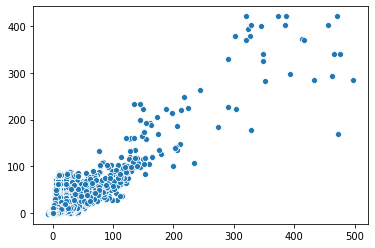

In [134]:
sns.scatterplot(X_train_level2[:,0], X_train_level2[:,1])

### Stacking

In [135]:
lr_st = LinearRegression()
lr_st.fit(X_train_level2, y_train_level2)
print('Normalized Coefficient: {}'.format(lr_st.coef_/lr_st.coef_.sum()))

Normalized Coefficient: [0.29272129 0.70727871]


In [136]:
train_preds = lr_st.predict(X_train_level2)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train_level2, train_preds))

test_preds = lr_st.predict(np.vstack((pred_lr, pred_lgb)).T)
rmse_test_stacking = np.sqrt(mean_squared_error(y_val, test_preds))

print('Train RMSE for stacking is %f' % rmse_train_stacking)
print('Test  RMSE for stacking is %f' % rmse_test_stacking)

Train RMSE for stacking is 2.523375
Test  RMSE for stacking is 5.430973


### Simple convex mix

In [111]:
alphas_to_try = np.linspace(0, 1, 1001)

rmse_scores = np.array([np.sqrt(mean_squared_error(y_train_level2, np.dot(X_train_level2, [alpha, 1-alpha])))
                      for alpha in alphas_to_try])
best_alpha = alphas_to_try[rmse_scores.argmax()]
rmse_train_simple_mix = rmse_scores.max()

print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, rmse_train_simple_mix))

Best alpha: 1.000000; Corresponding rmse score on train: 2.813734


In [112]:
test_preds = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb
rmse_test_simple_mix = np.sqrt(mean_squared_error(y_val, test_preds))

print('Test RMSE for simple mix is %f' % rmse_test_simple_mix)

Test RMSE for simple mix is 5.446038


# Download result

In [137]:
X_train.drop(to_drop_cols, axis=1).columns

Index(['shop_id', 'item_id', 'target_lag_1', 'target_item_lag_1',
       'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2',
       'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3',
       'target_shop_lag_3', 'target_lag_4', 'target_item_lag_4',
       'target_shop_lag_4', 'target_lag_5', 'target_item_lag_5',
       'target_shop_lag_5', 'target_lag_12', 'target_item_lag_12',
       'target_shop_lag_12', 'shop_id_mean_target', 'item_id_mean_target'],
      dtype='object')

In [138]:
X_test.drop(to_drop_cols, axis=1).drop(['date_block_num_', 'ID'], axis=1).columns

Index(['shop_id', 'item_id', 'item_id_mean_target', 'shop_id_mean_target',
       'target_item_lag_1', 'target_item_lag_12', 'target_item_lag_2',
       'target_item_lag_3', 'target_item_lag_4', 'target_item_lag_5',
       'target_lag_1', 'target_lag_12', 'target_lag_2', 'target_lag_3',
       'target_lag_4', 'target_lag_5', 'target_shop_lag_1',
       'target_shop_lag_12', 'target_shop_lag_2', 'target_shop_lag_3',
       'target_shop_lag_4', 'target_shop_lag_5'],
      dtype='object')

In [139]:
X_train.columns.shape

(26,)

In [140]:
pred_lgb_test = model.predict(X_test.drop(to_drop_cols, axis=1).drop(['date_block_num_', 'ID'], axis=1).values)

In [141]:
pred_lr_test = lr.predict(X_test.drop(to_drop_cols, axis=1).drop(['date_block_num_', 'ID'], axis=1).values)

In [142]:
X_test.columns

Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'date_block_num_',
       'item_id_mean_target', 'shop_id_mean_target', 'target', 'target_item',
       'target_item_lag_1', 'target_item_lag_12', 'target_item_lag_2',
       'target_item_lag_3', 'target_item_lag_4', 'target_item_lag_5',
       'target_lag_1', 'target_lag_12', 'target_lag_2', 'target_lag_3',
       'target_lag_4', 'target_lag_5', 'target_shop', 'target_shop_lag_1',
       'target_shop_lag_12', 'target_shop_lag_2', 'target_shop_lag_3',
       'target_shop_lag_4', 'target_shop_lag_5'],
      dtype='object')

In [146]:
np.vstack((pred_lr_test, pred_lgb_test)).T.shape

(214200, 2)

In [147]:
test_preds = lr_st.predict(np.vstack((pred_lr_test, pred_lgb_test)).T)

In [151]:
test_df['item_cnt_month'] = test_preds

In [153]:
test_df = test_df[['ID', 'item_cnt_month']]

In [154]:
test_df.to_csv('subm_result.csv', index=False)